### Credits : https://github.com/lukysummer/Movie-Review-Sentiment-Analysis-LSTM-Pytorch/blob/master/sentiment_analysis_LSTM.py

### Dataset from https://ai.stanford.edu/~amaas/data/sentiment/

In [54]:
# loading basic libraries
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from string import punctuation
import torch
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /home/u33552/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [55]:
#loading the dataset
review_data = pd.read_excel('movie_data.xlsx')
review_data.replace(pd.np.nan,'',inplace=True,regex=True)
review_data.head()

,review,label
0,it's a lovely movie it deeply reflects the Chi...,1
1,This 1998 film was based on a script by the la...,1
2,If you're going to put on a play within the pr...,1
3,At first sight this movie doesn't look like a ...,1
4,This adaptation of M.R. James's short story 'A...,1


In [56]:
# lets preprocess the data to remove punctuations and special characters. 
# Here wer removed everything that is not a character from a-z both lowercase and uppercase
# here we are also converting all the words to lowercase

review_data['review'] = review_data['review'].str.replace("[^a-zA-Z]"," ").apply(lambda x: str(x).lower())

In [57]:
#loading nltk stopwords for english
from nltk.corpus import stopwords
stopwords_english = stopwords.words('english')

In [58]:
# removing all words stopwords. We will use the nltk library list of stop words

review_data['review'] = review_data['review'].apply(lambda x:' '.join([word for word in str(x).split() if word not in stopwords_english ]))
review_data['review'].head()

0    lovely movie deeply reflects chinese undergrou...
1    film based script late edward wood script feat...
2    going put play within prison walls go top play...
3    first sight movie look like particular great o...
4    adaptation r james short story view hill first...
Name: review, dtype: object

In [59]:
#removing the words with length less than or equal to 2
review_data['review'] = review_data['review'].apply(lambda x:' '.join([word for word in str(x).split() if len(word)>2 ]))


In [60]:
review_data['review'].head()
# data looks good now

0    lovely movie deeply reflects chinese undergrou...
1    film based script late edward wood script feat...
2    going put play within prison walls top playwri...
3    first sight movie look like particular great o...
4    adaptation james short story view hill first s...
Name: review, dtype: object

In [61]:
# lets visualize most common words with wordcloud
# We will do visualization for both negative and positive labels as well as the whole data corpus itself


In [62]:
all_words = ' '.join(review_data['review'].tolist())
negative_words = ' '.join(review_data['review'][review_data['label']==0].tolist())
positive_words = ' '.join(review_data['review'][review_data['label']==1].tolist())

In [63]:
#defining a function that will generate word cloud for us

def generate_wordcloud(text,title):
    wc = WordCloud(width=800, height=400, max_font_size=110)
    wc.generate(text)
    plt.figure(figsize=(10, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()


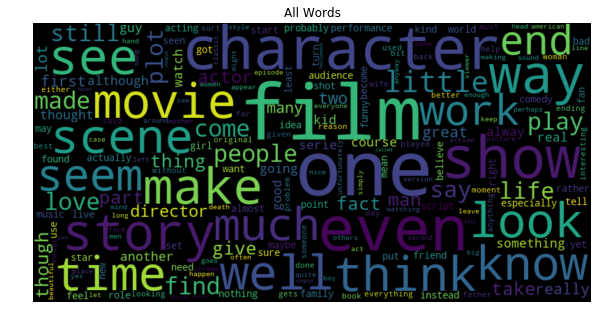

In [64]:
generate_wordcloud(all_words,'All Words')

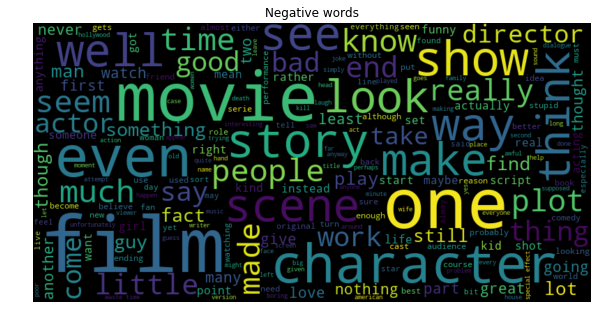

In [65]:
generate_wordcloud(negative_words,'Negative words')

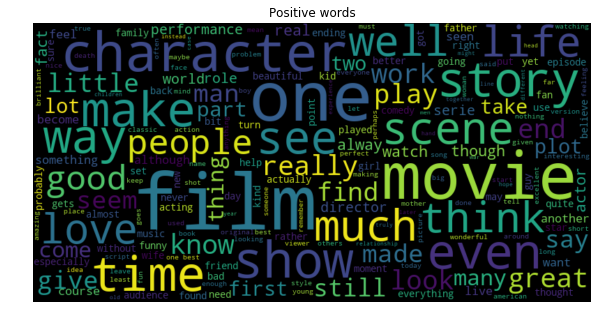

In [66]:
generate_wordcloud(positive_words,'Positive words')

## Create dictionaries and encode reviews

In [67]:
from collections import Counter
word_counts = Counter(all_words.split())
#sorted word list according to descending order. i.e biggest on at first position and so on
word_list = sorted(word_counts, key = word_counts.get, reverse = True)
# creating two dictionaries to map. word to index and map index to word.
# example 1--> movie-->1 --> word to index
# example 2--> movie --> index to word
word_to_index = {word:idx+1 for idx,word in enumerate(word_list)}
index_to_word = {idx+1:word for idx,word in enumerate(word_list)}

In [68]:
#encoding reviews
encoded_reviews = [[word_to_index[word] for word in review.split()] for review in review_data['review']]

## Encode label

In [69]:
encoded_labels = review_data['label']

In [70]:
# len of reviews should be equal to length of labels
assert len(encoded_reviews)==len(encoded_labels),"Number of of encoded reviews and encoded labels should be same"

### Removing empty reviews and labels--> i.e those reviews that had no text.--> they will have empty list in encoded matrix

In [71]:
encoded_labels = np.array([label for idx, label in enumerate(encoded_labels) if len(encoded_reviews[idx])>0])
encoded_reviews =  [review for review in encoded_reviews if len(review)>0]


In [72]:
# len of reviews should be equal to length of labels
assert len(encoded_reviews)==len(encoded_labels),"Number of of encoded reviews and encoded labels should be same"

### Making all reviews of same length i.e padding

In [73]:
#printing top 20 max length
len_max = ([len(x) for x in encoded_reviews])
print(sorted(list(len_max),reverse=True)[:20])

[1390, 1132, 1127, 1080, 920, 905, 889, 870, 802, 789, 787, 772, 727, 701, 690, 684, 673, 669, 629, 625]


In [74]:
# lets see how many reviews have text more than 500
len([review for review in len_max if review>499])

233

In [75]:
# lets see how many reviews have text more than 250
len([review for review in len_max if review>249])

4139

In [76]:
# lets see how many reviews have text more than 150
len([review for review in len_max if review>149])

11458

In [77]:
# lets see how many reviews have text more than 100
len([review for review in len_max if review>99])

20754

In [78]:
# lets see how many reviews have text less than 100
len([review for review in len_max if review<100])

29243

looks like majority of reviews have length less than 100. 

so a standard size of 250 should be enough to get all the features of a review.

also probably people will have expressed how they feel in their first 250 words.

so lets fix a standard review size of 250. in case if reviews are short. we will pad zeros. 

and in case reviews are long we will truncate them

In [79]:
# function to pad our encoded reviews/feature
def pad_features(reviews,max_length):
    """
    Return features of reviews where each review is padded with 0's or truncted to the max_length
    """
    
    features = []
    
    #pad or truncate each review
    for idx,row in enumerate(reviews):
        if len(row)>=max_length:
            features.append(row[:max_length])
        else:
            features.append(np.concatenate((np.zeros(max_length-len(row)),np.array(row))))
        
    return np.array(features)

In [80]:
# a simple sanity check
test_array = [[1,2,3,4],
    [1,2,3,4,5,6,7,8,9,10]]
pad_features(test_array,8)

array([[0., 0., 0., 0., 1., 2., 3., 4.],
       [1., 2., 3., 4., 5., 6., 7., 8.]])

In [81]:
# padding our reviews.We are calling our reviews features because 
# it makes sense to call it feature now as we will feed this feature to our model later
padded_features = pad_features(reviews = encoded_reviews,max_length = 250)

In [82]:
# checking if the number of feature is equal to number of reviews we passed
assert len(padded_features) == len(encoded_reviews),"Length Mismatch after padding"
assert len(padded_features[0]) == 250

## Splitting our data into training and testing set

In [83]:
total = padded_features.shape[0]
train_ratio = 0.8
# the plan is to use 80% of data for training and use remaining 20% for testing and validation
# we will split the remaining 20% into half and seperate into testing and validation sets
train_idx = int(total*0.8) #39997
train_x, remaining_x  = padded_features[:train_idx],padded_features[train_idx:]
train_y, remaining_y   = encoded_labels[:train_idx],encoded_labels[train_idx:]

#splitting the remaining 20% to validation and testing
test_idx = int(len(remaining_x)*0.5)
test_x,valid_x  = remaining_x[:test_idx],remaining_x[test_idx:]
test_y,valid_y = remaining_y[:test_idx],remaining_y[test_idx:]


In [84]:
#lets see the shape of our training,validation and testing data
print("\t\t\t Features Shape")
print("Train Set:\t\t{}".format(train_x.shape),
     "\nValidation Set:\t\t{}".format(valid_x.shape),
     "\nTesting Set\t\t{}".format(test_x.shape))

			 Features Shape
Train Set:		(39997, 250) 
Validation Set:		(5000, 250) 
Testing Set		(5000, 250)


In [85]:
#lets see the shape of labels for out training, validation and testing data
print("\t\t\t Label Shape")
print("Train Set:\t\t{}".format(train_y.shape),
     "\nValidation Set:\t\t{}".format(valid_y.shape),
     "\nTesting Set\t\t{}".format(test_y.shape))

			 Label Shape
Train Set:		(39997,) 
Validation Set:		(5000,) 
Testing Set		(5000,)


In [86]:
print('Total data After preprocessing: \nFeatures:{}\nLabels:{}'.format(padded_features.shape,encoded_labels.shape))

Total data After preprocessing: 
Features:(49997, 250)
Labels:(49997,)


In [87]:
## 80% of 49997 = 39997 approx
## 10% of 49997 = 5000 approx
## math checks out

### Loading the dataset and batching into DataLoaders


* we will use TensorDataset and DataLoader for this purpose
* TensorDataset takes Features and Labels with same dimension and creates a dataset
* DataLoader makes our Dataset into generator that will give us both features and labels in batch sizes

`train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))`

`train_loader = DataLoader(train_data, batch_size=batch_size)`

In [88]:
from torch.utils.data import TensorDataset, DataLoader


# create TensorDatasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data =  TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


batch_size = 50

#we will shuffle the data because if we remember our data was like first 25k were positive and the second 25k were negative
#this might result in biasness

# we will also drop the last batch(47) because since our data size is not a multiple of 50. 
# It will throw errors as we will explicityly use batch_size
train_loader = DataLoader(train_data,shuffle=True,batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data,shuffle=True,batch_size=batch_size,drop_last=True)
test_loader = DataLoader(test_data,shuffle=True,batch_size=batch_size,drop_last=True)

In [89]:
# lets visualize a batch of training data

dataiter = iter(train_loader)
sample_x,sample_y = dataiter.next()
print('Sample input size:{}'.format(sample_x.size()))
print('Sample Input:\n{}\n'.format(sample_x))
print('Sample Label size:{}'.format(sample_y.size()))
print('Sample Label:\n{}'.format(sample_y))
# here i fell like 250 might have been a large size. it might be a good idea to set 150  as max length for each review

Sample input size:torch.Size([50, 250])
Sample Input:
tensor([[   0.,    0.,    0.,  ...,  157.,  790.,  521.],
        [   0.,    0.,    0.,  ...,  190., 3771., 4997.],
        [   0.,    0.,    0.,  ...,   69.,   94.,  382.],
        ...,
        [   0.,    0.,    0.,  ..., 8295.,  239.,  777.],
        [   0.,    0.,    0.,  ...,  788.,  577.,  895.],
        [   0.,    0.,    0.,  ...,    9.,   17.,  681.]], dtype=torch.float64)

Sample Label size:torch.Size([50])
Sample Label:
tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1])


## Defining our LTSM model

In [90]:
#checking if GPU is available
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('Training on GPU')
else:
    print("Training on CPU")

Training on CPU


In [91]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

## Instantiate the network

Here, we'll instantiate the network. First up, defining the hyperparameters.

* vocab_size: Size of our vocabulary or the range of values for our input, word tokens.
* output_size: Size of our desired output; the number of class scores we want to output (pos/neg).
* embedding_dim: Number of columns in the embedding lookup table; size of our embeddings.
* hidden_dim: Number of units in the hidden layers of our LSTM cells. Usually larger is better performance wise. * * Common values are 128, 256, 512, etc.
* n_layers: Number of LSTM layers in the network. Typically between 1-3

In [92]:
# instantiate our model with hyper parameters

vocab_size = len(word_to_index)+2
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(104402, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Training

In [93]:

# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# save path to save our weights with best validation accuracy
save_path = 'best_validation.pt'

In [94]:
# training params
def train(model, criterion, optimizer, train_loader, batch_size, train_on_gpu, save_path):
    valid_loss_min = np.Inf
    epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

    counter = 0
    print_every = 100
    clip=5 # gradient clipping

    # move model to GPU, if available
    if(train_on_gpu):
        model.cuda()

    model.train()
    # train for some number of epochs
    for e in range(epochs):
        # initialize hidden state
        h = model.init_hidden(batch_size)

        # batch loop
        for inputs, labels in train_loader:
            counter += 1

            if(train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            model.zero_grad()

            # get the output from the model
            output, h = model(inputs, h)

            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()

            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for inputs, labels in valid_loader:

                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])

                    if(train_on_gpu):
                        inputs, labels = inputs.cuda(), labels.cuda()

                    output, val_h = model(inputs, val_h)
                    val_loss = criterion(output.squeeze(), labels.float())

                    val_losses.append(val_loss.item())

                model.train()

                # lets save the model with best validation accuracy. 
                # It makes sense that we shouldnot need to train the model everytime.
                if np.mean(val_losses) <= valid_loss_min:
                    print('Validation loss decreased ({:.6f} ---------> {:.6f}).\t Saving model...'.
                          format(valid_loss_min, np.mean(val_losses)))
                    torch.save(model.state_dict(),'./best_validation.pt')
                    valid_loss_min = np.mean(val_losses)

                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))

In [95]:
# training the model
train(model=net, criterion=criterion, optimizer=optimizer, train_loader=train_loader, batch_size=batch_size, train_on_gpu=train_on_gpu,save_path=save_path)

Validation loss decreased (inf ---------> 0.918707).	 Saving model...
Epoch: 1/4... Step: 100... Loss: 0.570334... Val Loss: 0.918707
Validation loss decreased (0.918707 ---------> 0.817312).	 Saving model...
Epoch: 1/4... Step: 200... Loss: 0.414509... Val Loss: 0.817312
Validation loss decreased (0.817312 ---------> 0.797254).	 Saving model...
Epoch: 1/4... Step: 300... Loss: 0.423455... Val Loss: 0.797254
Validation loss decreased (0.797254 ---------> 0.498557).	 Saving model...
Epoch: 1/4... Step: 400... Loss: 0.579667... Val Loss: 0.498557
Validation loss decreased (0.498557 ---------> 0.442506).	 Saving model...
Epoch: 1/4... Step: 500... Loss: 0.376895... Val Loss: 0.442506
Epoch: 1/4... Step: 600... Loss: 0.432887... Val Loss: 0.508432
Epoch: 1/4... Step: 700... Loss: 0.330953... Val Loss: 0.846675
Validation loss decreased (0.442506 ---------> 0.306914).	 Saving model...
Epoch: 2/4... Step: 800... Loss: 0.406822... Val Loss: 0.306914
Epoch: 2/4... Step: 900... Loss: 0.345423..

In [96]:

# load the model that got the best validation accuracy
net.load_state_dict(torch.load(save_path))

<All keys matched successfully>

### Testing


In [97]:
def test(model, criterion, test_loader, batch_size, train_on_gpu):
    """
    Tests and returns the accuracy and loss of the given model on the given dataset
    """
    test_losses = [] # track loss
    num_correct = 0
    
    # init hidden state
    h = model.init_hidden(batch_size)
    net.eval() # turning of back propagation
    
    #iterating over test data
    for inputs, labels in test_loader:
        # creating a new variable for the hidden state, othewise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
            
        #get predicted outputs
        output, h = net(inputs, h)
        
        #calculate loss
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())
        
        # convert the output probabilities to predicted class( 0 or 1)
        pred = torch.round(output.squeeze()) # rounds to nearest integer
        
        # compare prediction to true label
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        num_correct += np.sum(correct)
    
    # printing stats
    print('Test loss: {:.3f}'.format(np.mean(test_losses)))
    
    #accuracy over all test_data
    test_acc = num_correct/len(test_loader.dataset)
    print("Test accuracy: {:.3f} %".format(test_acc))

In [98]:
# testing performance of our model
test(model=net, criterion=criterion, test_loader=test_loader, batch_size=batch_size, train_on_gpu=train_on_gpu)

Test loss: 0.301
Test accuracy: 0.885 %


## Building a pipeline that takes a review and predicts the sentiment

* First, we will build a function to preprocess a given review. It will perform tokenization, cleaning, stopwords removal and finally pad the review

* Second, we will prepare a function that takes a review and outputs a sentiment

In [119]:
# building the preprocessor function

import re
from nltk.corpus import stopwords
stopwords_english = stopwords.words('english')
def process_review(review):
    """
    It will clean, tokenize, encode the review 
    """
    # 1. removing punctuations and numbers and other characters and to lowercase
    review = re.sub("[^a-zA-Z]"," ",review).lower()
    
    # 2. remove stopwords
    review = ' '.join([word for word in review.split() if word not in stopwords_english])
    
    # 3. remove words with length less than or equal to 2
    review = ' '.join([word for word in review.split() if len(word)>2])
    
    # 4. encoding review using our list of words that we generated earler
    encoded_review = [word_to_index[word] for word in review.split() if word in word_to_index]
    
    return encoded_review

In [120]:
test_review = 'The worst movie I have seen; acting was terrible and I want my money back. This movie had bad acting and the dialogue was slow.'
print(pad_features([process_review(test_review)],250))

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   

In [121]:
# creating the predictor function
def predict_review(model, review):
    """
    It will return the predicted sentiment of the review as predicted by our model
    """
    model.eval()
    
    # process and tokenize the review using `process_review` function
    review = process_review(review)
    
    # pad pad_featuresokenized review
    features = pad_features([review],250)
    
    # convert this numpy array to tensor ttorch.from_numpythe model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    #initialize the hidden state
    h = model.init_hidden(batch_size)
    
    if train_on_gpu:
        feature_tensor = feature_tensor.cuda()
        
    #get the outputfrom the model
    output, h  = model(feature_tensor, h)
    
    # convert output probabilities to predicted class 0 or 1
    pred = torch.round(output.squeeze())
    
    #printing output value before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
    #print  custom response
    
    if pred.item() ==1:
        print('Positive review detected')
    else:
        print('Negative review detected')

In [122]:
predict_review(net,test_review)

Prediction value, pre-rounding: 0.001733
Negative review detected


In [138]:
test_review_pos = 'This movie had the best acting and the dialogue was so good. I loved it.'
predict_review(net,test_review_pos)

Prediction value, pre-rounding: 0.994079
Positive review detected


In [139]:
test_review_pos = 'In three years, everyone will be happy.'
predict_review(net,test_review_pos)

Prediction value, pre-rounding: 0.955433
Positive review detected


In [143]:
test_negative_review = 'I don’t like their customer support'
predict_review(net,test_negative_review)
# shouldnot have removed the punctuations
#model seems preety stupid

Prediction value, pre-rounding: 0.641780
Positive review detected


In [142]:
test_negative_review = 'I was on hold for 40 minutes, their customer support service is a nightmare'
predict_review(net,test_negative_review)


Prediction value, pre-rounding: 0.151112
Negative review detected


## Testing with customer reviews


In [162]:
# testing with pros and cons
good_reviews = ['We want to remain a leader in a highly competitve inductry and hence one of our chief responsibility is to provide clean and accurate data to our clients. It is very critical for our business to acquire data on time. Before we started working with Grepsr, I researched and spoke to several other web scraping agencies and after doing a thourough analysis, came to a conclusion that Grepsr is the best provider for our use case. Setting up the projects with Grepsr was very easy and convenient and they were able to provide the data to us in minimum turnaround time and the lowest rates. They are easy to work with and definitely pros in this space. I would definitely recommend them to other organizations trying to solve their data acquisition problems.',
 'I run a small business part of which entails the collecting of data on a daily basis, before coming across Grepsr this was a time consuming onerous task. Now I need do no more than simply open the file to access all my data requirements. It is a very cost effective means of obtaining data and the service provided is without doubt the best of any software company I have dealt with in my 25-years of experience',
 'Our business model requires us to refresh our data very frequently. Grepsr has been instrumental in making that possible. Their speed and the quality of their work has always been top notch. If we ever have a problem, or would like a new feature, Grepsr responds within a day and makes the extra effort to meet our needs. ',
 'The grepsr data is key to our business',
 'Manual data extraction can be a labor intensive process. Using a service like Grepsr has been an excellent way to optimize my time on understanding what the data is telling me rather than programming my own scrapes to get this data. Grepsr has been an easy tool to work with supported by a strong and attentive team.',
 "Overall, I have been extremely pleased with Grepsr's product and service.",
 'I feel constantly updated about my request - Prompt replies by reps.',
 "I struggled a lot with DataMiner and still can't manage using it. Grepsr literally saved me, It's simply intuitive and easy to use.\nI had one page where data was taken not properly. After submitting information on to support they fixed that in one day. Such an amazing result even keeping in mind that I am not a paid, customer. Thanks a lot ",
 'It has been a great service and product.  We have found great value and continue to use them because of their delivery/quality, customer service, timeliness.  As a software business, we have clients that need their work as quick as possible.  The team at Grepsr always delivers.  ',
 'The tech team is very responsive and the in-account messaging service is very convenient.  Turnaround times are world-class.  I would not hesitate to recommend their services.',
 'GREPSR has been essential for me to gain insights around how conversation are taking place throughout a wide variety of mediums. GREPSR helps me to understand any thing from the latest perception in shoe sneakers, to how patients are talking in a highly specific online medical forum. ',
 'Had a positive experience working with their team. They were able to tailor some of the data templates and delivery for our business, at a small cost. Although it involved multiple iterations with some QC errors and back-and-forth, was satisfied with the end results.',
 'Customer service has been great.  They are very helpful getting the information you need.  ',
 'Grepsr has saved me literally thousands of dollars and man hours by providing me with the raw data to build content in my map driven website. ',
 'Grepsr is an action or a tool that "grep" (for grab -> extract -> process) data. \r\nGrepsr really is easy. Extracting data is a matter of explaining requirements. You can do this either through text or uploading a file (or snapshot) or using a browser addon. The user is encouraged to add as much detail as possible while specifying requirements. The Grepsr staff gets to work immediately after the request is submitted and promise to service your request within a single day.\r\nThe interface is clean and simple, with each tab corresponding to a particular system view including your projects and extractors. ',
 'Grepsr supplied us with test data needed for our automotive lease application. We were able to pass proof of concept with this information',
 'Customer service is  second to none. Pricing is fantastic for SMB to enterprise.',
 'Responsive customer support and a diligent team that strives to provide the best output - will highly recommend',
 'We routinely conduct detailed and sometimes obscure internet searches and crawls to support our top-end research studies.  I have rarely come across a more responsive and professional organization.  Grepsr does exactly what they say, faster than promised, and at excellent prices.',
 'We needed to grab from the interenet a specific list from several sources and it was perfectly done.',
 'Fantastic!']


(1, 2)


In [164]:
for review in (good_reviews)[:11]:
    print('-'*100)    
    print(review.replace('\n',' '))
    print()
    predict_review(net, review.replace('\n',' '))
    print('\n\n')

----------------------------------------------------------------------------------------------------
We want to remain a leader in a highly competitve inductry and hence one of our chief responsibility is to provide clean and accurate data to our clients. It is very critical for our business to acquire data on time. Before we started working with Grepsr, I researched and spoke to several other web scraping agencies and after doing a thourough analysis, came to a conclusion that Grepsr is the best provider for our use case. Setting up the projects with Grepsr was very easy and convenient and they were able to provide the data to us in minimum turnaround time and the lowest rates. They are easy to work with and definitely pros in this space. I would definitely recommend them to other organizations trying to solve their data acquisition problems.

Prediction value, pre-rounding: 0.985992
Positive review detected



--------------------------------------------------------------------------

In [165]:
for review in (cons)[:10]:
    print('-'*100)    
    print(review.replace('\n',' '))
    print()
    predict_review(net, review.replace('\n',' '))
    print('\n\n')

----------------------------------------------------------------------------------------------------
1. Being in a different timezone leads to a latency at times

Prediction value, pre-rounding: 0.942724
Positive review detected



----------------------------------------------------------------------------------------------------
I can honestly say that in my 5-years experience with the software I cannot find anything I would change

Prediction value, pre-rounding: 0.465046
Negative review detected



----------------------------------------------------------------------------------------------------
We have been very pleased with Grepsr throughout our partnership.

Prediction value, pre-rounding: 0.939745
Positive review detected



----------------------------------------------------------------------------------------------------
really no cons.  The team is very responsive to any sort of issues or feedback but issues are few and far between

Prediction value, pre-rounding: 0.97297

In [174]:
predict_review(net, 'i am   worst')

Prediction value, pre-rounding: 0.230621
Negative review detected
